In [70]:
import numpy as np
import os
import json
import pandas as pd
from utils.evaluation import *

data_path="/home/emartini/nas/MAEVE/dataset/panoptic-toolbox/trtpose3D/"

CONTINUOUS_STATE_PARTS = [
            "nose", "left_ear", "right_ear", "left_shoulder", "right_shoulder", 
            "left_elbow", "right_elbow", "left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", 
            "right_knee", "left_ankle", "right_ankle", "neck"]

# Load the json for comparison
mapping = [12, 7, 10, 4,  5, 9, 6, 8, 11, 3, 14, 13]
header = ["frame_id"]+[CONTINUOUS_STATE_PARTS[m] for m in mapping]

In [72]:
# Compared methods
from multiprocessing import Process, Manager
manager = Manager()

# cameras_list = [[6,7],[6,7,8],[6,7,8,9],[6,7,8,9,10]]
# cameras_list = [[6,7],[6,8],[6,9],[6,10],[7,8],[7,9],[7,10],[8,9],[8,10],[9,10]]

# All the combinantions
cameras_list = [[6], [7], [8], [9], [10]] +\
                generate_combinations([6,7,8,9,10],2)+\
                generate_combinations([6,7,8,9,10],3)+\
                generate_combinations([6,7,8,9,10],4)+\
                generate_combinations([6,7,8,9,10],5)

cameras_list = [[6,7]]

methods = ["befine","cometh"] # "befine","cometh"
sequences = ["170915_office1"] #"170915_office1","161029_tools1","161029_build1","161029_sports1"] # ,"160422_ultimatum1" too long ;;"170407_haggling_a1",
result = []

for sequence_name in sequences:
    print(sequence_name)
    for cameras in cameras_list:
        print("cams:",cameras)
        for method in methods:
            print(method)
            
            # Load ground truth
            GT = {}
            with open(os.path.join(data_path,sequence_name+".gt.json"), "r") as f:
                ground_truth = json.load(f)
            for frame in ground_truth:
                GT[frame["timestamp"]] = frame        

            # Load camera file
            DUT = {}
            with open(os.path.join(data_path,sequence_name+"."+ method+"." +".".join(map(str, cameras)) +".json" ), "r") as f:
                file = json.load(f)
            for frame in file:
                DUT[frame["timestamp"]] = frame    

            ## Build the triple nested list (shape: n_frames, n_people, n_joints, 3) and IDs (shape: n_frames, n_people)
            # union of both gt and camera            
            ids = list(GT.keys())
            for frame_dut in list(DUT.keys()):
                if frame_dut not in ids:
                    ids.append(frame_dut) 
                    
            predicted_keypoints = []
            predicted_ids = []
            ground_truth_keypoints = []
            ground_truth_ids = []
            for id in sorted(ids):
                predicted_keypoints_per_frame = []
                predicted_ids_per_frame = []
                ground_truth_keypoints_per_frame = []
                ground_truth_ids_per_frame = []
                if id in GT.keys():
                    for pp in GT[id]['continuousState']:
                        s = np.array([ [np.nan,np.nan,np.nan] if not f else f for f in pp])
                        s = s[mapping,:]
                        ground_truth_keypoints_per_frame.append(s)
                    for i in GT[id]['track_ids']:
                        ground_truth_ids_per_frame.append(i)
                if id in DUT.keys():
                    for i,pp in enumerate(DUT[id]['continuousState']):
                        s = np.array([ [np.nan,np.nan,np.nan] if not f else f for f in pp])
                        s = s[mapping,:]
                        if not np.isnan(s).all():
                            predicted_keypoints_per_frame.append(s)
                            # predicted_ids_per_frame.append(i)

                    # This doesn't work for cameras
                    for I in DUT[id]['track_ids']:
                        predicted_ids_per_frame.append(I)
                # print(id)
                # if id > 500:
                #     # print(GT[id]['continuousState'])
                #     # print(predicted_keypoints_per_frame)
                #     # print(predicted_ids_per_frame)
                #     # print(ground_truth_keypoints_per_frame)
                #     # print(ground_truth_ids_per_frame)
                #     break
                
                predicted_keypoints.append(predicted_keypoints_per_frame)
                predicted_ids.append(predicted_ids_per_frame)
                ground_truth_keypoints.append(ground_truth_keypoints_per_frame)
                ground_truth_ids.append(ground_truth_ids_per_frame)

            # print(predicted_keypoints)

            # Integral
            # res = [[]]*19
            res = manager.list()
            procs = []
            step = 0.05
            thread_id = 0
            while step < 1:
                # print(step)
                # loca, deta, detpr, detre, assa,asspr,assre, hot = hota(predicted_keypoints, predicted_ids, ground_truth_keypoints, ground_truth_ids,distance_threshold=step)
                # res.append([step, loca, deta, detpr, detre, assa,asspr,assre, hot])
                proc = Process(target=hota_par, args=(res,thread_id,predicted_keypoints, predicted_ids, ground_truth_keypoints, ground_truth_ids,step))
                
                procs.append(proc)
                proc.start()
                step += 0.05
                thread_id += 1

            for proc in procs:
                proc.join()
            res = list(res)
            
            # row = [sequence_name,len(cameras),method] + list(np.nanmean(np.array(res),0)[1:])
            row = [sequence_name,len(cameras),",".join(map(str, cameras)),method] + np.round(list(100*np.nanmean(np.array(res),0)),1).tolist()
            result.append(row)

header_stats = ["Sequence","#Cams","Cams", "Aggregator",  "LocA", "DetA", "DetPR", "DetRE", "AssA","AssPR","AssRE", "HOTA"]
df = pd.DataFrame(result,columns=header_stats)

170915_office1
cams: [6, 7]
befine
cometh


/tmp/ipykernel_3043491/2194695932.py:114: RuntimeWarning: Mean of empty slice
  row = [sequence_name,len(cameras),",".join(map(str, cameras)),method] + np.round(list(100*np.nanmean(np.array(res),0)),1).tolist()


In [73]:
# df2 = pd.read_csv(os.path.join(data_path,'results.csv'))
# df1 = pd.DataFrame(result,columns=header_stats)
# df = pd.merge(df1,df2,how='outer')
# df.groupby(["#Cams","Aggregator"]).mean()
# df.to_csv(os.path.join(data_path,'results.csv'), index=False)
df
df.to_csv(os.path.join(data_path,sequence_name+'.csv'), index=False)


['170915_office1', 2, '6,7', 'cometh', nan, 0.0, 0.0, 0.0, nan, nan, nan, nan]

In [69]:
DF = df
# DF = pd.read_csv(os.path.join(data_path,'results.csv'))
cam_grouped = DF.groupby(["#Cams","Aggregator"]).mean()
# df.groupby(["#Cams","Aggregator"]).mean()
DF.groupby(["Aggregator","#Cams"]).mean()

LocA   DetA  DetPR   DetRE   AssA  AssPR   AssRE   HOTA
Aggregator #Cams                                                          
befine     1      72.46  75.36  81.24   91.84  86.18  93.18   91.84  79.98
           2      81.82  82.39  82.88   99.32  98.87  99.50   99.32  89.63
           3      85.86  74.86  74.93   99.85  99.73  99.88   99.85  85.74
           4      87.40  66.66  66.66   99.96  99.86  99.90   99.96  81.08
           5      88.10  58.40  58.40  100.00  99.90  99.90  100.00  76.40
cometh     1      69.68  65.18  76.86   82.28  19.90  94.14   20.28  33.58
           2      78.19  64.93  70.40   82.65  78.56  98.28   79.27  70.95
           3      83.38  68.56  70.46   93.50  91.04  99.90   91.12  78.38
           4      85.48  64.24  64.78   98.24  96.86  99.94   96.92  78.38
           5      86.50  56.70  56.80   99.60  99.40  99.90   99.50  75.10

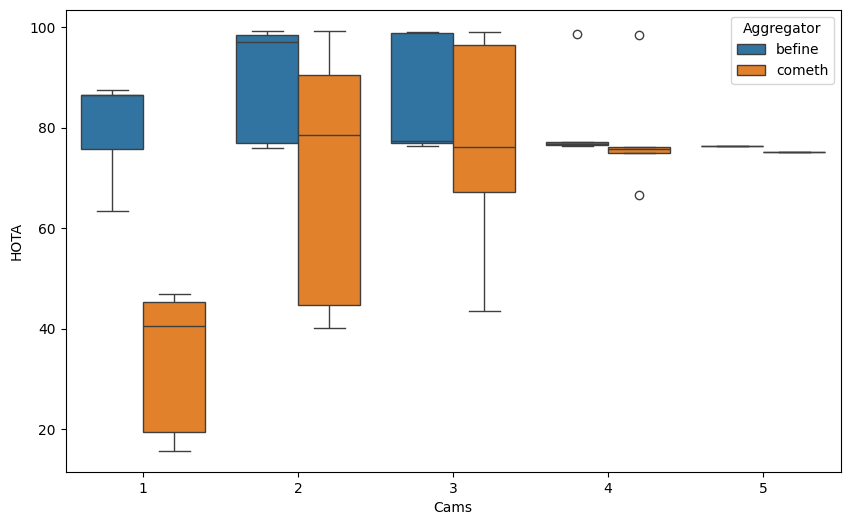

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
#.unstack().boxplot(column="HOTA",by="Aggregator",title="HOTA",ylim=(0,100))
# cam_grouped["HOTA"].unstack().plot(kind='bar',title="HOTA",ylim=(0,100))
# cam_grouped["DetA"].unstack().plot(kind='bar',title="DetA",ylim=(0,100))
# cam_grouped["AssA"].unstack().plot(kind='bar',title="AssA",ylim=(0,100))
# cam_grouped["LocA"].unstack().plot(kind='bar',title="LocA",ylim=(0,100))
# DF[["Aggregator","#Cams","HOTA"]].groupby(["Aggregator","#Cams"]).min()
plt.figure(figsize=(10, 6))
sns.boxplot(x='#Cams', y='HOTA', hue='Aggregator',  data=DF)
# plt.title('Boxplot of HOTA by #Cams')
plt.xlabel('Cams')
plt.ylabel('HOTA')
plt.show()

In [ ]:
# Build qualitative json method vs ground truth (matching based on frame_id)
import collections
result = collections.Counter(list(DUT.keys())) & collections.Counter(list(GT.keys()))
intersected_list = list(result.elements())
# print(DUT.keys())
out = []
for i in intersected_list:
    f_gt = GT[i]
    f_dut = DUT[i]
    summed = f_gt.copy()
    summed["kp3d"] += f_dut["kp3d"]
    summed["kp2d"] += f_dut["kp2d"]
    summed["continuousState"] += f_dut["continuousState"]
    summed["track_ids"] += [id + 50 for id in f_dut["track_ids"]]
    # print(summed)
    # print(f_gt["timestamp"],f_dut["timestamp"])
    out.append(summed)
    # break

# dump json
filename = os.path.join(data_path,sequence_name+".gt_vs_"+method+"." +".".join(map(str, cameras))+".json")
print("Written",filename)

with open(filename, "w") as outfile:
    json.dump(out, outfile)

# Export in viewer format
os.system('python3 to_viewer.py ' + filename + ' --rotation 180 --output '+filename.replace('.json','.viewer.json')+' >> "tmp/"$1"_log_2.txt"')

In [ ]:
# Build qualitative json method vs ground truth (matching based on timestamps)
GT_t = {}
for frame in list(GT.keys()):
    GT_t[GT[frame]["timestamp"]] = GT[frame]

DUT_t = {}
for frame in list(DUT.keys()):
    DUT_t[DUT[frame]["timestamp"]] = DUT[frame]
          
import collections
result = collections.Counter(list(DUT_t.keys())) & collections.Counter(list(DUT_t.keys()))
intersected_list = list(result.elements())
# print(DUT.keys())
intersected_list.remove(0)
out = []
for i in intersected_list:
    print(i)
    summed = {}
    f_gt = GT_t[i]
    f_dut = DUT_t[i]
    # summed = f_gt.copy()
    summed["timestamp"] = f_gt["timestamp"]
    summed["frame_id"] = f_gt["frame_id"]
    summed["kp3d"] = f_gt["kp3d"]+f_dut["kp3d"]
    summed["kp2d"] = f_gt["kp2d"]+f_dut["kp2d"]
    summed["continuousState"] = f_gt["continuousState"]+f_dut["continuousState"]
    summed["track_ids"] = f_gt["track_ids"]+ [id + 50 for id in f_dut["track_ids"]]

    out.append(summed)

# dump json
filename = os.path.join(data_path,sequence_name+".gt_vs_"+method+"." +".".join(map(str, cameras))+".json")

with open(filename, "w") as outfile:
    json.dump(out, outfile)

# Export in viewer format
os.system('python3 to_viewer.py ' + filename + ' --rotation 180 --output '+filename.replace('.json','.viewer.json')+' >> "tmp/"$1"_log_2.txt"')